In [36]:
import django, sys, os
sys.path.append('/home/max/software/django-tmv/tmv_mcc-apsis/BasicBrowser')
os.environ.setdefault("DJANGO_SETTINGS_MODULE", "BasicBrowser.settings")
django.setup()

from scoping.models import *
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from itertools import product, combinations
from utils.text import *
from pycountry_convert import  country_alpha2_to_continent_code, country_alpha3_to_country_alpha2
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import seaborn as sns

import pandas as pd


In [2]:
df = pd.read_csv('../data/category_predictions.csv')


pred_cats = [c for c  in df.columns if "12 - " in c and " - mean_prediction" in c]

for c in pred_cats:
    print(df[c].sum())
    label = c.replace(" - mean_prediction",'')
    df.loc[df[label]==1,c] = 1
    print(df[c].sum())
print(pred_cats)

attrib_cats = [c for c  in df.columns if "2 - " in c and " - mean_prediction" in c and not "12 - " in c]
for c in attrib_cats:
    print(df[c].sum())
    label = c.replace(" - mean_prediction",'')
    df.loc[df[label]==1,c] = 1
    print(df[c].sum())
attrib_cats


df.head()

1994.0
2135.833333333333
7694.166666666668
7977.833333333335
3508.5
3682.3333333333335
28089.166666666668
28527.000000000004
6168.333333333334
6409.000000000001
['12 - Mountains, snow and ice - mean_prediction', '12 - Rivers, lakes, and soil moisture - mean_prediction', '12 - Coastal and marine Ecosystems - mean_prediction', '12 - Terrestrial ES - mean_prediction', '12 - Human and managed - mean_prediction']
37018.0
37444.333333333336
26211.0
26536.166666666664
1869.0000000000002
1975.0000000000002


,Unnamed: 0,id,content,title,wosarticle__de,wosarticle__wc,ar5,seen,relevant,12 - Coastal and marine Ecosystems,...,6 - Water availability - k_prediction,6 - Water availability - k_prediction_binary,6 - Temperature - mean_prediction,6 - Temperature - std_prediction,6 - Temperature - lower_pred,6 - Temperature - upper_pred,6 - Precipitation - mean_prediction,6 - Precipitation - std_prediction,6 - Precipitation - lower_pred,6 - Precipitation - upper_pred
0,0,136746,"Grasslands, one of the most widespread land co...",Dynamic of grassland vegetation degradation an...,Grassland degradation; Climate change; Human i...,['Ecology'],0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,1284614,Tree-ring width chronologies from the upper ti...,Separating temperature from precipitation sign...,Northeastern Tibetan Plateau; Tree-ring width;...,"['Geography, Physical; Geosciences, Multidisci...",0.0,0.0,0.0,0.0,...,NaN,NaN,1.000000,0.000000,1.0,1.000000,0.333333,0.471405,0.0,0.804738
2,2,1344242,This study examines the spatial and temporal p...,GIS analysis of spatial and temporal patterns ...,fire; geographic information systems; manageme...,['Forestry'],0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,289649,"Permafrost, mainly of discontinuous type, that...","Thermokarst lake, hydrological flow and water ...",Permafrost; Thermokarst lakes; Hydrological cy...,"['Engineering, Civil; Geosciences, Multidiscip...",0.0,0.0,0.0,0.0,...,NaN,NaN,0.166667,0.372678,0.0,0.539345,1.000000,0.000000,1.0,1.000000
4,4,399966,"Since 2005, Morocco has designated 28 Importan...",Factors Influencing Species-Richness of Breedi...,Breeding waterfowl; Diversity; Spatial scale; ...,['Ecology; Environmental Sciences'],0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
geos = pd.read_csv('../data/geo_df.csv')
geos = geos.drop_duplicates(["doc_id","geonameid"])
print(geos.shape)
geos.head()

(105576, 9)


,admin1,lat,lon,country_code3,geonameid,place_name,feature_class,feature_code,doc_id
0,NaN,39.76000,-98.5000,USA,6252001,United States,A,PCLI,3305893
1,NaN,22.00000,79.0000,IND,1269750,Republic of India,A,PCLI,1477550
2,NaN,60.00000,100.0000,RUS,2017370,Russian Federation,A,PCLI,1477550
3,Punjab,31.47060,74.3488,PAK,7043356,Pakistan Foundation Technical Institute,S,SCHC,1477550
4,NaN,3.51342,-132.1875,NaN,2363254,Pacific Ocean,H,OCN,1477550


In [138]:
places = pd.read_csv('../data/place_df.csv').query("country_conf>0.85")
places = places[places["word"]!="Holocene"]
places.head()

,Unnamed: 0,word,spans,country_predicted,country_conf,geo,doc_id
0,0,United States,"[{'start': 427, 'end': 440}]",USA,0.999811,"{'admin1': 'NA', 'lat': '39.76', 'lon': '-98.5...",3305893
3,3,India,"[{'start': 140, 'end': 145}]",IND,0.999398,"{'admin1': 'NA', 'lat': '22', 'lon': '79', 'co...",1477550
4,4,Russia,"[{'start': 697, 'end': 703}]",RUS,0.999401,"{'admin1': 'NA', 'lat': '60', 'lon': '100', 'c...",1477550
5,5,Pakistan,"[{'start': 763, 'end': 771}]",PAK,0.989610,"{'admin1': 'Punjab', 'lat': '31.4706', 'lon': ...",1477550
7,7,Russia,"[{'start': 983, 'end': 989}]",RUS,0.999401,"{'admin1': 'NA', 'lat': '60', 'lon': '100', 'c...",1477550


In [139]:
df_places = pd.merge(df,places,left_on="id",right_on="doc_id")
df_places.head()

,Unnamed: 0_x,id,content,title,wosarticle__de,wosarticle__wc,ar5,seen,relevant,12 - Coastal and marine Ecosystems,...,6 - Precipitation - std_prediction,6 - Precipitation - lower_pred,6 - Precipitation - upper_pred,Unnamed: 0_y,word,spans,country_predicted,country_conf,geo,doc_id
0,0,136746,"Grasslands, one of the most widespread land co...",Dynamic of grassland vegetation degradation an...,Grassland degradation; Climate change; Human i...,['Ecology'],0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,86174,China,"[{'start': 157, 'end': 162}]",CHN,0.999764,"{'admin1': 'NA', 'lat': '35', 'lon': '105', 'c...",136746
1,0,136746,"Grasslands, one of the most widespread land co...",Dynamic of grassland vegetation degradation an...,Grassland degradation; Climate change; Human i...,['Ecology'],0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,86175,Qinghai,"[{'start': 1777, 'end': 1784}]",CHN,0.993103,"{'admin1': 'Qinghai', 'lat': '36', 'lon': '96'...",136746
2,0,136746,"Grasslands, one of the most widespread land co...",Dynamic of grassland vegetation degradation an...,Grassland degradation; Climate change; Human i...,['Ecology'],0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,86176,Inner Mongolia,"[{'start': 1786, 'end': 1800}]",CHN,0.993103,"{'admin1': 'Inner Mongolia', 'lat': '43.5', 'l...",136746
3,0,136746,"Grasslands, one of the most widespread land co...",Dynamic of grassland vegetation degradation an...,Grassland degradation; Climate change; Human i...,['Ecology'],0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,86177,Xinjiang,"[{'start': 1806, 'end': 1814}]",CHN,0.993103,{'admin1': 'Xinjiang Uyghur Autonomous Region'...,136746
4,0,136746,"Grasslands, one of the most widespread land co...",Dynamic of grassland vegetation degradation an...,Grassland degradation; Climate change; Human i...,['Ecology'],0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,86178,Gansu,"[{'start': 1922, 'end': 1927}]",CHN,0.993103,"{'admin1': 'Gansu', 'lat': '37.75', 'lon': '10...",136746


In [140]:
import pycountry_convert as pc
def get_cont(x):
    try:
        return pc.country_alpha2_to_continent_code(pc.country_alpha3_to_country_alpha2(x['country_predicted']))
    except:
        return None
df_places['continent'] = df_places.apply(lambda x: get_cont(x), axis=1)


In [141]:
af_ids = df_places.loc[(df_places['continent']=="AF"),'id']

In [142]:
df_geo = pd.merge(df.loc[df['id'].isin(af_ids),],geos,left_on="id",right_on="doc_id")
df_geo.head()

bad_ids = ['9858236','9967606','4100592','4295982','5228874','4379445','5459219','7195491','5268166','4381982','5554419','5833847','4878074','5020546','5650274','7172853']
print(df_geo.shape)
df_geo=df_geo[~df_geo['geonameid'].isin(bad_ids)]
print(df_geo.shape)

(7482, 327)
(7424, 327)


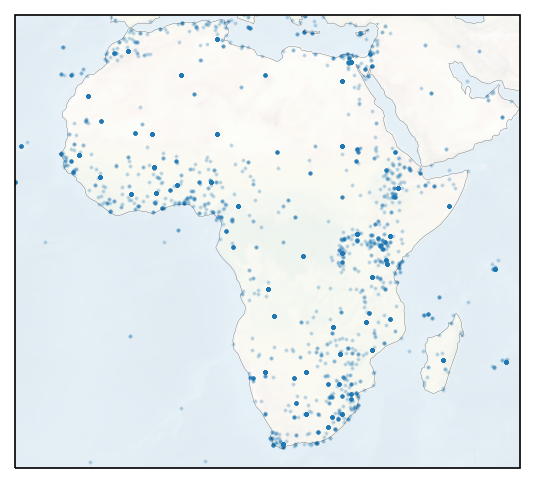

In [143]:
fig, ax = plt.subplots(dpi=150)
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines(lw=0.1)
ax.stock_img(alpha=0.2)
ax.set_extent([-25,60,-30,30])
ax.scatter(df_geo['lon'], df_geo['lat'],alpha=0.2,s=1)
plt.savefig('../plots/maps/predicted_places_africa.png',bbox_inches="tight")

In [144]:
len(set(af_ids))

3279

In [145]:
af_places = df_places.loc[df_places['continent']=="AF",]
c_size = (af_places
          .groupby('country_predicted')['id']
          .aggregate("count")
          .sort_values(ascending=False)
          .reset_index()
          .rename(columns={"id":"count"})
         )
c_size.head()

,country_predicted,count
0,ZAF,1418
1,ETH,609
2,KEN,548
3,TZA,443
4,EGY,369


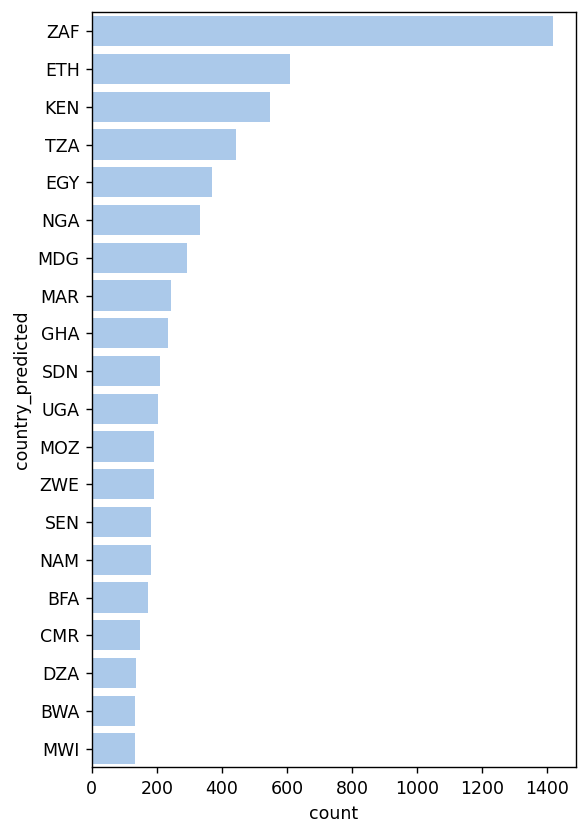

In [146]:
fig, ax = plt.subplots(dpi=125,figsize=(5,8))
sns.set_color_codes("pastel")
sns.barplot("count","country_predicted",  data=c_size.head(20), orient="h",color="b")
plt.savefig('../plots/literature_distribution/by_country_africa.png',bbox_inches="tight")

In [147]:
df_places.loc[df_places['id']==209653,]

,Unnamed: 0_x,id,content,title,wosarticle__de,wosarticle__wc,ar5,seen,relevant,12 - Coastal and marine Ecosystems,...,6 - Precipitation - lower_pred,6 - Precipitation - upper_pred,Unnamed: 0_y,word,spans,country_predicted,country_conf,geo,doc_id,continent
9465,5871,209653,The maritime plateau glacier of northern Folge...,Utilizing physical sediment variability in gla...,glacier fluctuations; North Atlantic Oscillati...,"['Geography, Physical; Geosciences, Multidisci...",0.0,0.0,0.0,0.0,...,0.0,0.0,89991,Norway,"[{'start': 219, 'end': 225}]",NOR,0.999981,"{'admin1': 'NA', 'lat': '62', 'lon': '10', 'co...",209653,EU
9466,5871,209653,The maritime plateau glacier of northern Folge...,Utilizing physical sediment variability in gla...,glacier fluctuations; North Atlantic Oscillati...,"['Geography, Physical; Geosciences, Multidisci...",0.0,0.0,0.0,0.0,...,0.0,0.0,89993,Norway,"[{'start': 1110, 'end': 1116}]",NOR,0.999981,"{'admin1': 'NA', 'lat': '62', 'lon': '10', 'co...",209653,EU
9467,5871,209653,The maritime plateau glacier of northern Folge...,Utilizing physical sediment variability in gla...,glacier fluctuations; North Atlantic Oscillati...,"['Geography, Physical; Geosciences, Multidisci...",0.0,0.0,0.0,0.0,...,0.0,0.0,89994,Norway,"[{'start': 1194, 'end': 1200}]",NOR,0.999981,"{'admin1': 'NA', 'lat': '62', 'lon': '10', 'co...",209653,EU
9468,5871,209653,The maritime plateau glacier of northern Folge...,Utilizing physical sediment variability in gla...,glacier fluctuations; North Atlantic Oscillati...,"['Geography, Physical; Geosciences, Multidisci...",0.0,0.0,0.0,0.0,...,0.0,0.0,89996,Scandinavia,"[{'start': 2093, 'end': 2104}]",NOR,0.921324,"{'admin1': 'Oslo', 'lat': '59.9177', 'lon': '1...",209653,EU


In [158]:
seen_ids = df.loc[df['seen']==1,"id"]

In [159]:
m = np.zeros((len(attrib_cats),len(pred_cats)),int)
adf = df.loc[df["id"].isin(af_ids),]
for i, ac in enumerate(attrib_cats):
    for j, pc in enumerate(pred_cats):
        df_comb = adf.loc[(adf[ac]>0.5) & (adf[pc]>0.5),]
        print(f'\n {ac.split(" - ")[1]} - {pc.split(" - ")[1]}: {df_comb.shape[0]} documents')
        df_comb['comb'] = df_comb[ac] + df_comb[pc]
        for ri, row in df_comb[~df_comb['id'].isin(seen_ids)].sort_values("comb",ascending=False).head(1).iterrows():
            print(row['title'])
            print(row[ac],row[pc])
            print(row['content'])
            print(row['id'])
            
            
        m[i,j]=df_comb.shape[0]


 Trend or climate change attribtion - Mountains, snow and ice: 9 documents
Hydrological Response to Snow Cover Changes Using Remote Sensing over the Oum Er Rbia Upstream Basin, Morocco
1.0 1.0
Water supply for the arid irrigated plains in Morocco depends largely on the upper mountainous basins where significant amounts of precipitation fall as snow. In the Oum Er-Rbia River Basin (OER), snow covers the highest elevations from November to April. Despite the importance of this component in the hydrological cycle, snowmelt contribution to streamflow is still poorly understood and no monitoring stations exist in this zone. Therefore, studying the spatiotemporal change of snow cover through satellite observations to investigate its influence on the hydrological response of this scarce region is thus required to better manage water resources. This chapter explores basic characteristics of snow cover area (SCA) in the upstream area of the OER River (Tillouguite sub-basin) using MODIS daily s

/home/max/software/django-tmv/tmv/venv/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [149]:
attrib_cats

['2 - Trend or climate change attribtion - mean_prediction',
 '2 - 2.4. Sensitivity - mean_prediction',
 '2 - 2.5. Detection of a regional climate trend (no attribution) - mean_prediction']

In [150]:
attrib_labels = ["Attribution","Sensitivity","Detection"]

In [151]:
pred_cats

['12 - Mountains, snow and ice - mean_prediction',
 '12 - Rivers, lakes, and soil moisture - mean_prediction',
 '12 - Coastal and marine Ecosystems - mean_prediction',
 '12 - Terrestrial ES - mean_prediction',
 '12 - Human and managed - mean_prediction']

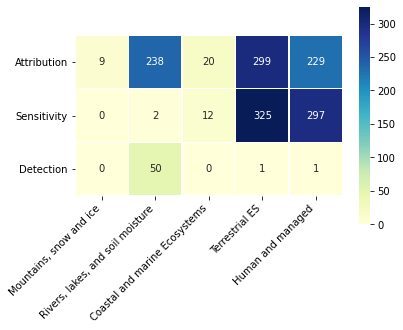

In [152]:
fig, ax = plt.subplots()
sns.heatmap(m,cmap="YlGnBu",ax=ax, linewidths=.5,square=True,annot=True,fmt="d")
ax.set_yticklabels(attrib_labels,rotation=0)
ax.set_xticklabels([x.split(" - ")[1] for x in pred_cats],rotation=45,ha="right")

plt.savefig('../plots/literature_distribution/heatmap_study_types_africa.pdf',bbox_inches="tight")

In [ ]:
pdf = (df_places[['id']+pred_cats+attrib_cats]
       .melt(id_vars=["id","continent","PY"])
       .query('value>0.5')
       .groupby(['PY','continent','variable'])['value']
       .aggregate("count")
       .reset_index()
       .query('PY<2020')
       .query('continent!="AN"')
       .query('PY>1990')
       .rename(columns={"value":"N studies"})
      )

In [73]:
pdf = (df_places[['id']+pred_cats+attrib_cats]
       .melt(id_vars=["id"])
       .query('value>0.5')
       #.pivot(indexcolumns="variable")
      )
pdf

,id,variable,value
146,1301455,"12 - Mountains, snow and ice - mean_prediction",1.000000
147,1301455,"12 - Mountains, snow and ice - mean_prediction",1.000000
236,654360,"12 - Mountains, snow and ice - mean_prediction",1.000000
237,654360,"12 - Mountains, snow and ice - mean_prediction",1.000000
238,654360,"12 - Mountains, snow and ice - mean_prediction",1.000000
...,...,...,...
2290462,1808630,2 - 2.5. Detection of a regional climate trend...,0.833333
2290463,1808630,2 - 2.5. Detection of a regional climate trend...,0.833333
2290504,2316945,2 - 2.5. Detection of a regional climate trend...,0.666667
2290505,2316945,2 - 2.5. Detection of a regional climate trend...,0.666667


In [74]:
pdf = (df_places[['id']+pred_cats+attrib_cats]
       .melt(id_vars=["id"])
       .query('value>0.5')
       .pivot(index="id",columns="variable")
      )
pdf

ValueError: Index contains duplicate entries, cannot reshape